In [1]:
import os

In [2]:
%pwd

'c:\\projects\\Kidney-Disease-Classification\\Kidney-Disease-Classification-MLflow-DVC\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\projects\\Kidney-Disease-Classification\\Kidney-Disease-Classification-MLflow-DVC'

In [5]:
import dagshub
dagshub.init(repo_owner='baryouly', repo_name='Kidney-Disease-Classification-MLflow-DVC', mlflow=True)

Accessing as baryouly

Initialized MLflow to track repo "baryouly/Kidney-Disease-Classification-MLflow-DVC"

Repository baryouly/Kidney-Disease-Classification-MLflow-DVC initialized!

In [6]:
import tensorflow as tf

In [7]:
model = tf.keras.models.load_model("artifacts/training/model.h5")
model

In [8]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model:Path 
    training_data:Path
    all_params:dict
    mlflow_uri:str
    params_image_size:list
    params_batch_size: int
    

In [9]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml , create_directories , save_json

In [10]:
class ConfigurationManager:
    def __init__(
            self,
            config_filepath=CONFIG_FILE_PATH,
            params_filepath=PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    def get_evaluation_config(self)-> EvaluationConfig :
        eval_config=EvaluationConfig(
            path_of_model="artifacts/training/model.h5",
            training_data="artifacts\data_ingestion\demo kideny dataset",
            mlflow_uri="https://dagshub.com/baryouly/Kidney-Disease-Classification-MLflow-DVC.mlflow",
            all_params=self.params,
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )
        return eval_config



In [11]:
import tensorflow as tf
from pathlib import Path
import mlflow
import mlflow.keras
from urllib.parse import urlparse



In [12]:
class Evaluation :
    def __init__(self,config : EvaluationConfig):
        self.config = config


    def _valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.30
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator= valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

    @staticmethod
    def load_model(path:Path) -> tf.keras.Model :
        return tf.keras.models.load_model(path)
    
    def evaluation(self):
        self.model=self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score= self.model.evaluate(self.valid_generator)
        self.save_score()

    def save_score(self):
        scores={"loss": self.score[0], "accuracy" : self.score[1]}
        save_json(path=Path("scores.json"), data=scores)
    
    def log_into_mlflow(self):
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_score = urlparse(mlflow.get_tracking_uri()).scheme

        with mlflow.start_run():
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics(
                {"loss":self.score[0] , "accuracy" : self.score[1]}
            )
            if tracking_url_type_score !="file" : 


                mlflow.keras.log_model(self.model,"model" , registered_model_name = "VGG16Model")
            else : 
                mlflow.keras.log_model(self.model , "model")

        

In [13]:
try : 
    config = ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(eval_config)
    evaluation.evaluation()
    evaluation.log_into_mlflow()

except Exception as e :
    raise e

[2025-03-23 22:13:48,178 : INFO:common:yamlfile : config\config.yaml loaded successfully]
[2025-03-23 22:13:48,193 : INFO:common:yamlfile : params.yaml loaded successfully]
[2025-03-23 22:13:48,196 : INFO:common:created directory at artifacts]
Found 2207 images belonging to 2 classes.
138/138 [==============================] - 356s 3s/step - loss: 3.2380 - accuracy: 0.6343
[2025-03-23 22:19:45,065 : INFO:common:json file saved at : scores.json]


2025/03/23 22:19:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


[2025-03-23 22:19:49,739 : WARNING:save:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 14). These functions will not be directly callable after loading.]
INFO:tensorflow:Assets written to: C:\Users\baryo\AppData\Local\Temp\tmpu22_1snd\model\data\model\assets
[2025-03-23 22:19:51,249 : INFO:builder_impl:Assets written to: C:\Users\baryo\AppData\Local\Temp\tmpu22_1snd\model\data\model\assets]


c:\Users\baryo\anaconda3\envs\kidney\lib\site-packages\_distutils_hack\__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'VGG16Model' already exists. Creating a new version of this model...
2025/03/23 22:21:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: VGG16Model, version 2
Created version '2' of model 'VGG16Model'.


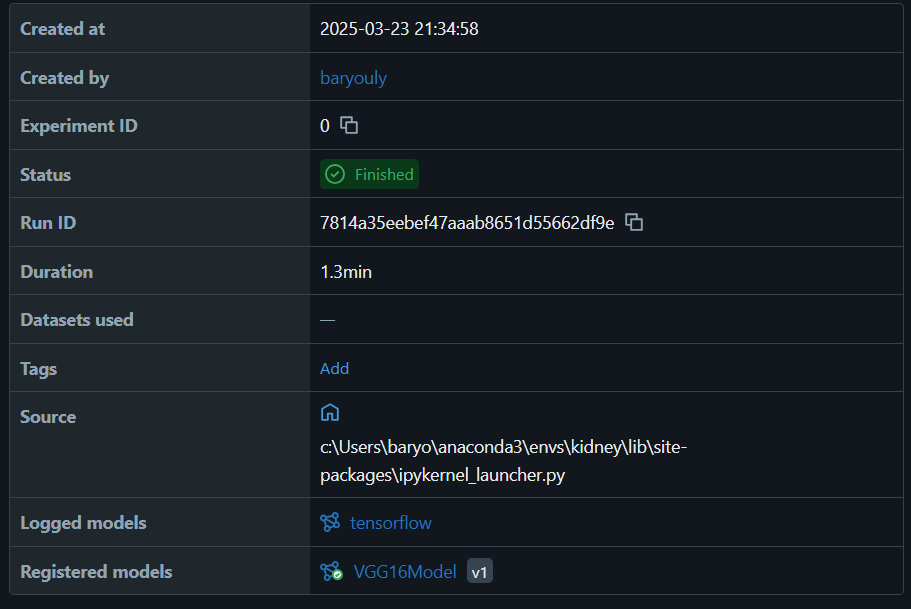

After modifying the model parameters, we compared different versions of the model on the MLflow interface to evaluate their performance. This allowed us to analyze the impact of parameter changes and identify the most optimal configuration.